# Sorting errors

author: steeve.laquitaine@epfl.ch

Setup environment: 

```bash
pip install requirements_kilosort_silico
```


In [10]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(proj_path)

from src.pipes.sorting import match_sorted_to_true_neuropixels_2023_02_19 as match
from src.nodes.utils import get_config
from src.nodes.postpro.cell_matching import match_firing_rate, match_property
from src.nodes.postpro import feateng

# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"


# GET RUN CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

CELL_MATCHING_PATH = data_conf["postprocessing"]["cell_matching"]

LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot"
MID_RATE_CEILING = 1    # max firing rate where positive proba change is observed in "bias plot"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-03-15 19:26:51,010 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-15 19:26:51,030 - root - utils.py - get_config - INFO - Reading experiment config. - done


1. get "cell_matching" dataset with firing rate  
2. select low firing rate cells (below 0.2Hz) with overestimated firing rate  
        a. count cells  
3. count cells with false positive spikes  
4. count overmerged cells (> 0.2)  

In [11]:
# get SpikeInterface's MatchingObject
out = match.run()

2023-03-15 19:26:51,899 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-03-15 19:26:51,913 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.0
2023-03-15 19:26:51,914 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-03-15 19:26:51,924 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.0
2023-03-15 19:27:07,953 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-03-15 19:27:07,958 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [12]:
# load from file
cell_matching = pd.read_parquet(CELL_MATCHING_PATH)

# add features
cell_matching = match_firing_rate(cell_matching, data_conf)

2023-03-15 19:27:08,213 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-03-15 19:27:08,228 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.0
2023-03-15 19:27:08,231 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-03-15 19:27:08,241 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.0
2023-03-15 19:27:26,594 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-03-15 19:27:26,600 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [13]:
# flag negative, positive, non probability biased firing rates
cell_matching = feateng.add_p_bias(cell_matching, low_rate_ceiling=LOW_RATE_CEILING, mid_rate_ceiling=MID_RATE_CEILING)

# flag overestimated, underestimated, same firing rates
cell_matching = feateng.add_firing_rate_change(cell_matching)

# add number of false positive spikes
cell_matching = feateng.add_false_positive_spikes_count(cell_matching, out["MatchingObject"])

In [14]:
cell_matching.groupby(["p_bias", "rate_change_feat"]).count()

sorted_cell  true_cell_match  \
p_bias     rate_change_feat                                 
neg_p_bias overestimated             169              169   
           underestimated             10               10   
no_p_bias  overestimated              21               21   
           underestimated             41               41   
pos_p_bias overestimated              30               30   
           underestimated             32               32   

                             oversplit_true_cell  agreement_score  \
p_bias     rate_change_feat                                         
neg_p_bias overestimated                     169              169   
           underestimated                     10               10   
no_p_bias  overestimated                      21               21   
           underestimated                     41               41   
pos_p_bias overestimated                      30               30   
           underestimated                     32               32   

                             true firing rate  ks3 firing rate  fp_spike_count  
p_bias     rate_change_feat                                                     
neg_p_bias overestimated                  169              169             169  
           underestimated                  10               10              10  
no_p_bias  overestimated                   21               21              21  
           underestimated                  41               41              41  
pos_p_bias overestimated                   30               30              30  
           underestimated                  32               32              32

In [15]:
# count
overestimated_higher_frs = ((cell_matching["p_bias"]=="pos_p_bias") | (cell_matching["p_bias"]=="no_p_bias")) & (cell_matching["rate_change_feat"]=="overestimated")
with_fp_spike = cell_matching["fp_spike_count"]>0
n_total = sum(overestimated_higher_frs)

# count false positive spikes cells given condition
n_with_fp_spike = sum((overestimated_higher_frs) & (with_fp_spike))
n_without_fp_spike = n_total - n_with_fp_spike
percent_with_fp_spikes = n_with_fp_spike/n_total
percent_without_fp_spikes = n_without_fp_spike/n_total

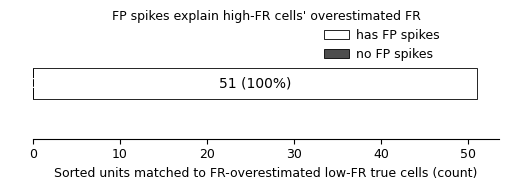

In [16]:
from matplotlib import pyplot as plt

# build histo dataset
data_df = pd.DataFrame(
    {
        "cell count": [
            n_with_fp_spike,
            n_without_fp_spike,
        ],
    },
    index=["has FP spikes", "no FP spikes"],
)

# set figure
fig, axis = plt.subplots(1, 1, figsize=(5, 2))

# set plot legend
# colors = [[0.87, 0.92, 0.96], "w"]
colors = ["w", [0.3, 0.3, 0.3]]
txt_colors = ["k", "w"]
percents = [percent_with_fp_spikes, percent_without_fp_spikes]

# plot
ax = data_df.T.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.2,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xlabel("Sorted units matched to FR-overestimated low-FR true cells (count)", fontsize=9)
ax.legend(
    bbox_to_anchor=(0.6, 0.6),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
ax.set_title("FP spikes explain high-FR cells' overestimated FR", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

# annotate bars with count by sorting error type
for p_i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    ax.text(
        x + width / 2,
        y + height / 2,
        "{:.0f} ({:.0f}%)".format(width, percents[p_i]*100),
        horizontalalignment="center",
        verticalalignment="center",
        color=txt_colors[p_i],
    )

In [17]:
OVERMERGED_SCORE = 0

overmerged_units = out["MatchingObject"].get_overmerged_units(overmerged_score=OVERMERGED_SCORE)

# count the overmerging conditions
n_overmerged = len(set(overmerged_units) & set(cell_matching["sorted_cell"][overestimated_higher_frs]))
n_not_overmerged = n_total - n_overmerged
percent_overmerged = n_overmerged/n_total*100
percent_not_overmerged = n_not_overmerged/n_total*100

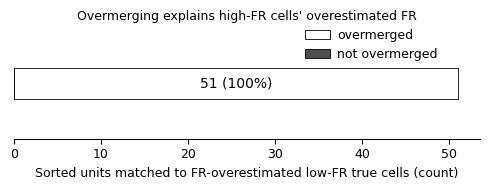

In [25]:
from matplotlib import pyplot as plt

# build histo dataset
data_df = pd.DataFrame(
    {
        "cell count": [
            n_overmerged,
            n_not_overmerged,
        ],
    },
    index=["overmerged", "not overmerged"],
)

# set figure
fig, axis = plt.subplots(1, 1, figsize=(5, 2))

# set plot legend
colors = ["w", [0.3, 0.3, 0.3]]
txt_colors = ["k", "k"]
percents = [percent_overmerged, percent_not_overmerged]

# plot
ax = data_df.T.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.2,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xlabel("Sorted units matched to FR-overestimated low-FR true cells (count)", fontsize=9)
ax.legend(
    bbox_to_anchor=(0.6, 0.6),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
ax.set_title("Overmerging explains high-FR cells' overestimated FR", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

# annotate bars with count by sorting error type
x_shift = 0
for p_i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    if not width==0:
        if not width==0:
            ax.text(
                x + width / 2 + x_shift,
                y + height / 2,
                "{:.0f} ({:.0f}%)".format(width, percents[p_i]),
                horizontalalignment="center",
                verticalalignment="center",
                color=txt_colors[p_i],
        )

Overmerged units have an agreement score above 0.2 with two or more ground-truth units [Buccino et al., 2020, p. 16].

In [17]:
print("overmerged score:", out["MatchingObject"].overmerged_score)
out["MatchingObject"].get_overmerged_units()

overmerged score: 0.2


[222]